# Bitcoin's price distribution over time

This brief notebook will look at Bitcoin's daily price change percentage, the distribution's underlying parameters and examine how this distribution has changed over time as a way to estimate regime change. 

In [9]:
import requests
import pandas as pd
import pandas_datareader.data as pdr
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as grid_spec

from tqdm import tqdm
from datetime import datetime

from scipy import stats  

plt.style.use('seaborn')

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

# 1. Data source

In [3]:
symbol ='BTC-USD'

start = datetime(2014, 1, 1)
end = datetime(2021, 4, 11)

In [4]:
stock = pdr.get_data_yahoo(symbol, start, end, interval='d')
stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,468.174011,452.421997,465.864014,457.334015,21056800.0,457.334015
2014-09-17,456.859985,413.104004,456.859985,424.440002,34483200.0,424.440002
2014-09-18,427.834991,384.532013,424.102997,394.795990,37919700.0,394.795990
2014-09-19,423.295990,389.882996,394.673004,408.903992,36863600.0,408.903992
2014-09-20,412.425995,393.181000,408.084991,398.821014,26580100.0,398.821014


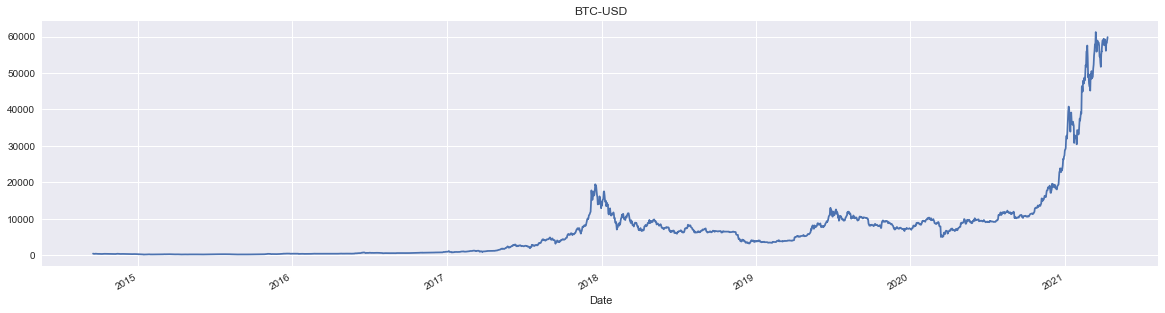

In [5]:
stock.columns = list(stock.columns.str.lower())
stock['volume'] = stock['volume'].astype(float)
stock['pct_chg'] = stock['open'].pct_change()
stock.dropna(inplace=True)
stock['open'].plot(figsize=(20,5), title=f'{symbol}'), plt.show();

# 2. Fitting laplace and normal distributions

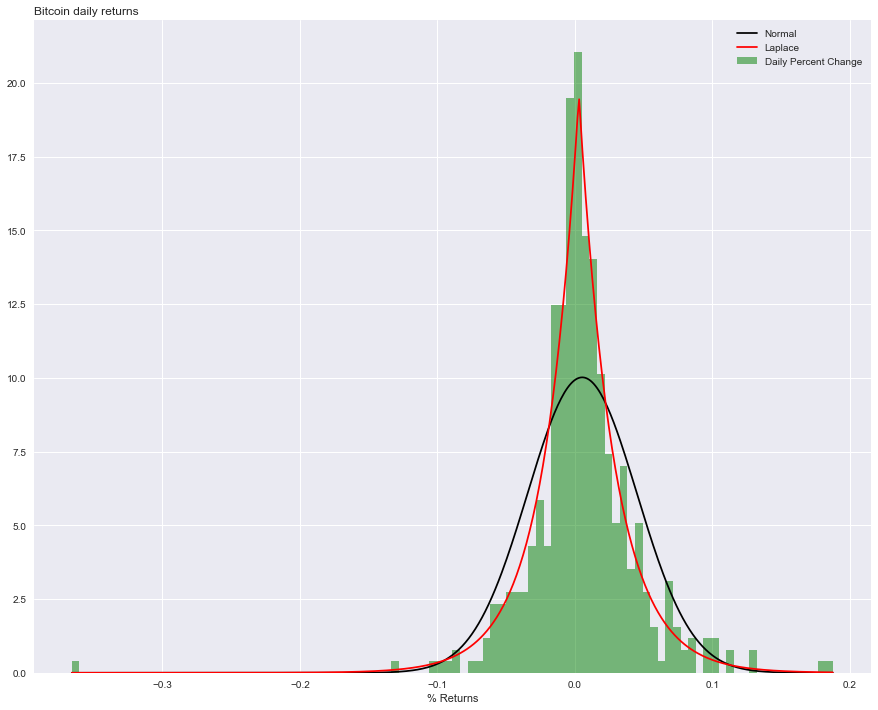

In [10]:
subset = stock[stock.index >= '2020-01-01']['pct_chg']
x = subset.values

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xmin, xmax = min(x), max(x)  
lnspc = np.linspace(xmin, xmax, len(x))

plt.rcParams['figure.figsize'] = (15, 12)

# get laplace distribution parameters and plot it alongside daily % change
ag,bg = stats.laplace.fit(x)   #loc, scale
pdf_laplace = stats.laplace.pdf(lnspc, ag, bg)  

#compare to normal dist
u, s = stats.norm.fit(x)
pdf_norm = stats.norm.pdf(lnspc, u, s) 

plt.plot(lnspc, pdf_norm, label="Normal", color='black')
plt.plot(lnspc, pdf_laplace, label="Laplace", color='r')

subset.hist(bins=100, density=True, label='Daily Percent Change', color='green', alpha=0.5)

plt.title('Bitcoin daily returns', loc='left')
plt.xlabel('% Returns')
plt.legend()

Unsuprisingly, the distribution more closely resembles the laplace family. We can use the probability density to estimate likelihood of certain price change values falling within a given range. If using a mean-reversion or channel based trading strategy, this information could be useful in providing accurate estimates of price boundaries.

In [7]:
#normalize so we can sum sections of the pdf easier
pdf_laplace = stats.laplace.pdf(lnspc, ag, bg)
normed_laplace = pdf_laplace/np.sum(pdf_laplace)

Probability of price changes appearing in this range is approx 0.627082830747778


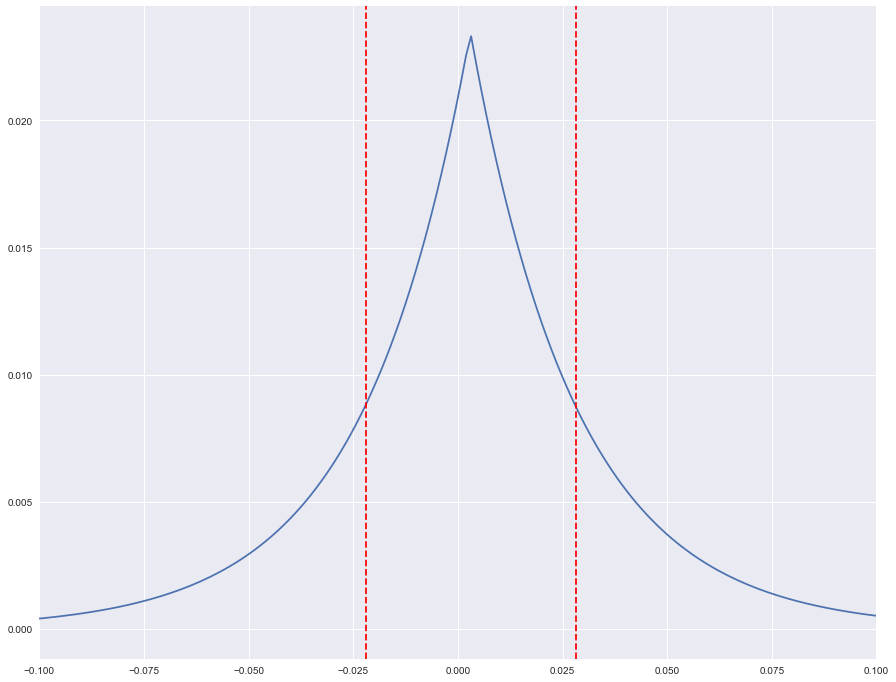

In [8]:
idx = find_nearest(lnspc, -0.0226)[1]
end_idx = find_nearest(lnspc, 0.0285)[1]

plt.plot(lnspc, normed_laplace, label="Laplace PDF")
plt.axvline(lnspc[idx], color='r', linestyle='--')
plt.axvline(lnspc[end_idx], color='r', linestyle='--')
plt.xlim(-0.1,0.1)

price_range_aoc = normed_laplace[idx:end_idx].sum()
print(f'Probability of price changes appearing in this range is approx {price_range_aoc}')

# 3. Price change distributions over time
Very simple of way of visualizing regime change - next steps would be to attempt to predict future period parameter distributions, assuming there exists some seasonality or obvious repeating pattern. This is not likely to be the case.

## 3.1 Ridge plot


In [125]:
start = '2018-01-01'
end = '2021-04-30'

stock_1y = stock[(stock.index >= start) & (stock.index <= end)].copy()
stock_1y.loc[:, 'period'] = stock_1y.index.month_name()  + stock_1y.index.year.astype(str)

data = stock_1y.copy()

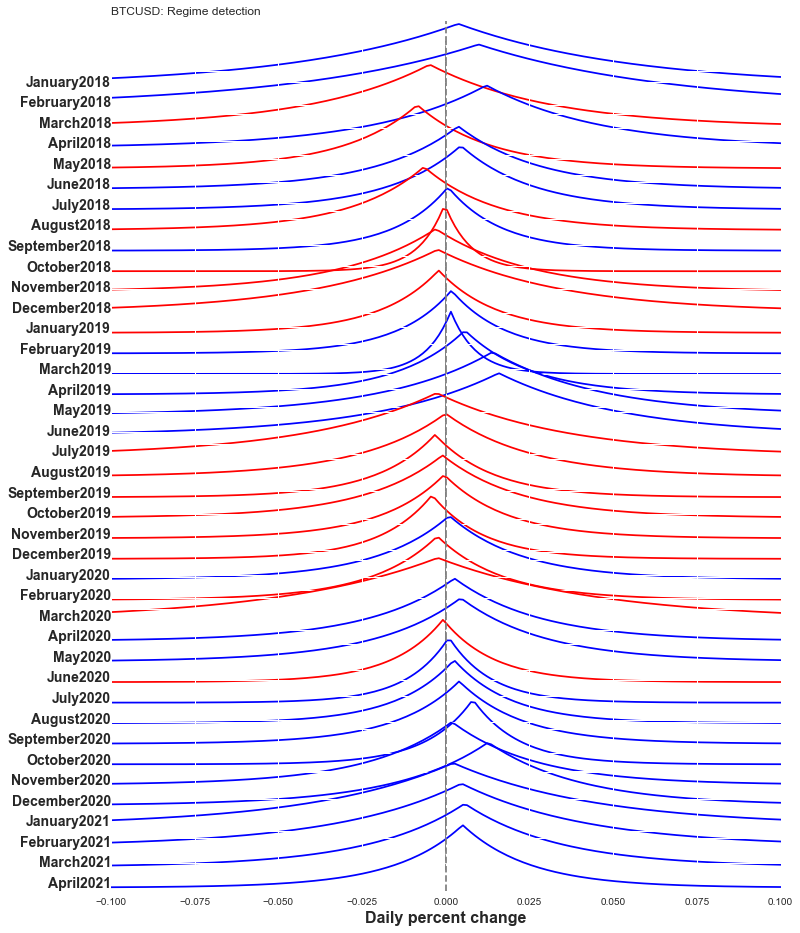

In [126]:
periods = data['period'].unique()

gs = grid_spec.GridSpec(len(periods),1)
fig = plt.figure(figsize=(12,16))

i = 0

loc_list = []
scale_list = []
per_list = []

ax_objs = []
for period in periods:
    period = periods[i]
    x = np.array(data[data.period == period].pct_chg)
    
    per_list.append(period)

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    if i == 0:
        ax_objs[-1].set_title('BTCUSD: Regime detection', loc='left')

    # plotting the distribution
        
    ag,bg = stats.laplace.fit(x)   #loc, scale
    pdf_laplace = stats.laplace.pdf(lnspc, ag, bg)    
    
    if ag < 0:
        color = 'r'
    else:
        color = 'b'
    
    ax_objs[-1].plot(lnspc, pdf_laplace, label="Laplace", color=color)
    
    #u, s = stats.norm.fit(x)
    #pdf_norm = stats.norm.pdf(lnspc, u, s) 
    #ax_objs[-1].plot(lnspc, pdf_norm, label="Norm", color='black')
    
    loc_list.append(ag)
    scale_list.append(bg)
    
    plt.axvline(0, color='gray', linestyle='--')
    
    ax_objs[-1].set_xlim(-0.1,0.1)

    
    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(periods)-1:
        ax_objs[-1].set_xlabel("Daily percent change", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_period = period.replace(" ","\n")
    ax_objs[-1].text(-0.1,0,adj_period,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.7)


#plt.tight_layout()
plt.show()

Not surprisingly, periods marked in red (where the central tendency of daily price change was negative) correspond to bear market periods during Bitcoin's history. It appears that bear and bull market periods usually appear over many months, however there isn't any obvious pattern in typical duration of said periods. <br><br>
This is reflected in the time series visualization of the distribution's parameters. Next steps are to attempt to forecast these values to predict regime.

In [127]:
param_df = pd.DataFrame()
param_df['period'] = per_list
param_df['loc'] = loc_list
param_df['scale'] = scale_list

param_joined = stock_1y[['period']].reset_index().copy()
param_joined = param_joined.merge(param_df, how='inner', on='period')
param_joined.set_index('Date',inplace=True) #or Date

<AxesSubplot:xlabel='Date'>

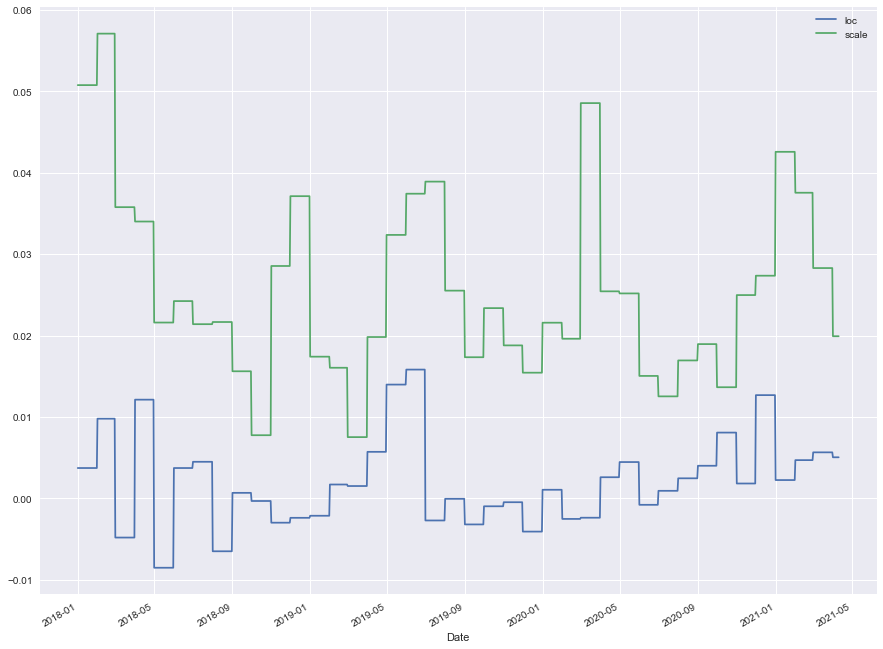

In [128]:
param_joined[['loc', 'scale']].plot()